In [1]:
% matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss

import gsw as sw
from mpl_toolkits.basemap import Basemap, cm, interp

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Times New Roman'})


/Users/sclayton/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def distance(data):
    distances = pd.DataFrame()    
    # calculate distance in km between points
    data['dx'] = np.insert(sw.distance(data['Lon'].values, data['Lat'].values, 0),0,0)/1000
    data['x'] = np.cumsum(data['dx'])

    return data  

def bin(pgram, periods, bins, bin_mid):
    
    y = periods
    
    binned = pd.DataFrame()
    bin_count = np.zeros(len(bins)-1)
    binned['k_mid'] = bin_mid
          
    z = pgram # bead attribute

    digitized = np.digitize(y, bins)
    bin_count = [np.shape(z[digitized == i])[0] for i in range(1, len(bins))]

    bin_means = [np.nanmean(z[digitized == i]) for i in range(1, len(bins))]
    bin_std = [np.nanstd(z[digitized == i]) for i in range(1, len(bins))]
        
    binned['var'] = bin_means
    binned['std'] = bin_std

    return binned


In [3]:
# import data

# import data

maxlat = 35

KM = pd.read_csv(r'/Users/sclayton/Google Drive/o2ar_data/KM1314_vSept16.csv', sep = ',')
KM['density'] = sw.rho(KM['S'].values,KM['T'].values,0)
KM = distance(KM)
KM = KM[KM['Lat']<maxlat].dropna().reset_index(drop = True)

ST = pd.read_csv(r'/Users/sclayton/Google Drive/o2ar_data/STUD08_vSept16.csv', sep = ',')
ST['density'] = sw.rho(ST['S'].values,ST['T'].values,0)
ST = distance(ST)
ST = ST[ST['Lat']<maxlat].dropna().reset_index(drop = True)

print ST.columns

Index([u'Timestamp', u'Lat', u'Lon', u'S', u'T', u'Fluo (calibrated)',
       u'TrueO2Ar', u'O2Arsat', u'O2Arbiosat', u'MLD (WOA13)', u'Wkn',
       u'Air-sea flux', u'density', u'dx', u'x'],
      dtype='object')


number of segments =  5
for 20 - 200km range
estimated slope for NCP =  -1.80968738478 , r =  -0.880717808551 , p-value < 0.05  True
estimated slope for T =  -1.55051213155 , r =  -0.864639710149 , p-value < 0.05  True
 
for 5 - 20km range
estimated slope for NCP =  -1.40105607645 , r =  -0.732929933087 , p-value < 0.05  True
estimated slope for T =  -1.5898083136 , r =  -0.786355605576 , p-value < 0.05  True


/Users/sclayton/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


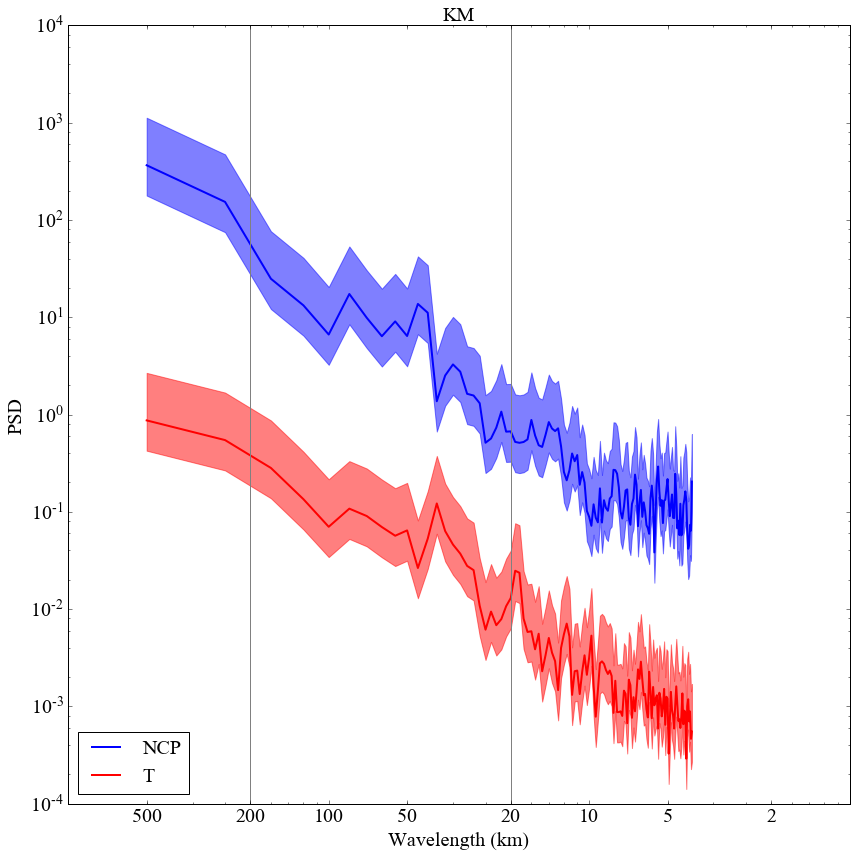

In [4]:
Tok1 = KM

# FFT
M = 500;
dx = 2
# for Tokyo_1 cruise
N = np.max(Tok1['x'].values) - np.min(Tok1['x'].values)
n = 0
ll = 0
Tok1['nx'] = Tok1['x'] - np.min(Tok1['x'].values)

freq = np.fft.fftfreq(M/dx, d=dx)
pgram = np.zeros(len(freq))
pgramT = np.zeros(len(freq))

data_int = pd.DataFrame()

data_int['x'] = np.arange(Tok1['nx'][0], Tok1['nx'][len(Tok1)-1], dx)
data_int['NCP'] = np.interp(data_int['x'].values, Tok1['nx'], Tok1['Air-sea flux'])
data_int['T'] = np.interp(data_int['x'].values, Tok1['nx'], Tok1['T'])


while n < (N - M):
    
    data = data_int[(data_int['x']>=n) &(data_int['x']<(n+M))]
    # get linear trend
    m, c, rR, p, std_err = ss.linregress(data['x'], data['NCP'])
    trend = m*data['x'].values + c 
    det_data = data['NCP'].values-trend
    
    mT,cT, rR, p, std_err = ss.linregress(data['x'], data['T'])
    trendT = mT*data['x'].values + cT 
    det_dataT = data['T'].values-trendT


    pgram += np.abs(np.fft.fft((det_data)*np.hanning(len(det_data))))**2
    pgramT += np.abs(np.fft.fft((det_dataT)*np.hanning(len(det_dataT))))**2
    
    n += M/2
    ll += 1

pgram = (pgram/len(data_int)*2)[1:125]
pgramT = (pgramT/len(data_int)*2)[1:125]
freq = freq[1:125]

nu = 2*(ll)
err_high = nu/ss.chi2.ppf(0.05/2, nu)
err_low = nu/ss.chi2.ppf(1-0.05/2, nu)


fig1 = plt.figure(3, figsize=(12,12), dpi = 600)

plt.plot(freq, pgram, 'b', lw=2, label='NCP')
plt.fill_between(freq, pgram*err_low, pgram*err_high, color='blue', alpha = 0.5)

plt.plot(freq, pgramT, 'r', lw=2, label='T')
plt.fill_between(freq, pgramT*err_low, pgramT*err_high, color='red', alpha = 0.5)

plt.legend(loc = 'lower left', fontsize = 20)
plt.tick_params(labelsize=20)

plt.yscale('log')
plt.xscale('log')

plt.ylabel('PSD', fontsize = 20)
plt.xlabel('Wavelength (km)', fontsize = 20)
plt.xticks(1./np.array([500, 200, 100, 50, 20, 10, 5, 2]), [500, 200, 100, 50, 20, 10, 5, 2])

plt.axvline(1./200, color = 'grey')
plt.axvline(1./20, color = 'grey')


plt.title('KM',fontsize = 20)

print 'number of segments = ',ll

print 'for 20 - 200km range'
yy = np.where((1/freq>=20) & (1/freq<=200))
m,c, r, p, std_err = ss.linregress(np.log10(freq[yy]),np.log10(pgram[yy]))
mT,cT, rT, pT, std_errT = ss.linregress(np.log10(freq[yy]),np.log10(pgramT[yy]))

print 'estimated slope for NCP = ', m, ', r = ', r, ', p-value < 0.05 ', p<0.05
print 'estimated slope for T = ', mT, ', r = ', rT, ', p-value < 0.05 ', pT<0.05

print ' '
print 'for 5 - 20km range'
yy = np.where((1/freq>=5) & (1/freq<=20))
m,c, r, p, std_err = ss.linregress(np.log10(freq[yy]),np.log10(pgram[yy]))
mT,cT, rT, pT, std_errT = ss.linregress(np.log10(freq[yy]),np.log10(pgramT[yy]))

print 'estimated slope for NCP = ', m, ', r = ', r, ', p-value < 0.05 ', p<0.05
print 'estimated slope for T = ', mT, ', r = ', rT, ', p-value < 0.05 ', pT<0.05

plt.show()

#fig1.savefig('../figures/NCP_T_FFT_May11.png', bbox_inches='tight', dpi=600)

T1_ncp = pgram
T1_t = pgramT
T1_err_low = err_low
T1_err_high = err_high

number of segments =  4
for 20 - 200km range
estimated slope for NCP =  -2.2500518311 , r =  -0.843967318472 , p-value < 0.05  True
estimated slope for T =  -1.94648920536 , r =  -0.918716806445 , p-value < 0.05  True
 
for 5 - 20km range
estimated slope for NCP =  -3.74866627436 , r =  -0.902213865856 , p-value < 0.05  True
estimated slope for T =  -3.62050774316 , r =  -0.929981904123 , p-value < 0.05  True


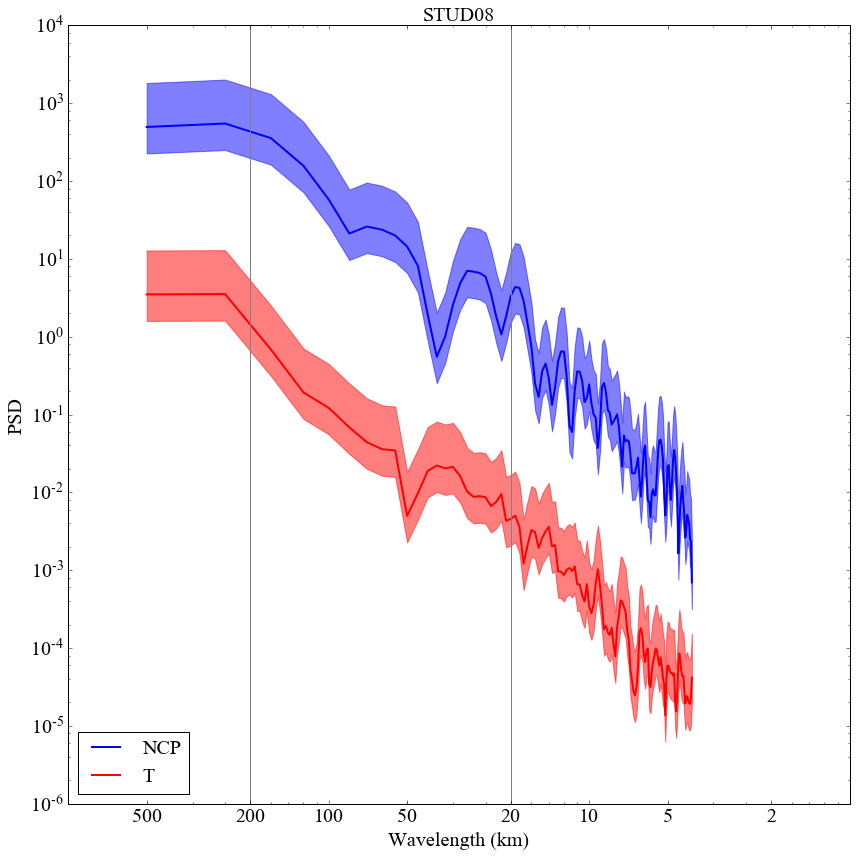

In [5]:
# FFT
Tok3 = ST

# for Tokyo_3 cruise
N = np.max(Tok3['x'].values) - np.min(Tok3['x'].values)
n = 0
ll = 0
Tok3['nx'] = Tok3['x'] - np.min(Tok3['x'].values)

freq = np.fft.fftfreq(M/dx, d=dx)
pgram = np.zeros(len(freq))
pgramT = np.zeros(len(freq))

data_int = pd.DataFrame()

data_int['x'] = np.arange(Tok3['nx'][0], Tok3['nx'][len(Tok3)-1], dx)
data_int['NCP'] = np.interp(data_int['x'].values, Tok3['nx'], Tok3['Air-sea flux'])
data_int['T'] = np.interp(data_int['x'].values, Tok3['nx'], Tok3['T'])


while n < (N - M):
    
    data = data_int[(data_int['x']>=n) &(data_int['x']<(n+M))]
    # get linear trend
    m, c, rR, p, std_err = ss.linregress(data['x'], data['NCP'])
    trend = m*data['x'].values + c 
    det_data = data['NCP'].values-trend
    
    mT,cT, rR, p, std_err = ss.linregress(data['x'], data['T'])
    trendT = mT*data['x'].values + cT 
    det_dataT = data['T'].values-trendT


    pgram += np.abs(np.fft.fft((det_data)*np.hanning(len(det_data))))**2
    pgramT += np.abs(np.fft.fft((det_dataT)*np.hanning(len(det_dataT))))**2
    
    n += M/2
    ll += 1

pgram = (pgram/len(data_int)*2)[1:125]
pgramT = (pgramT/len(data_int)*2)[1:125]
freq = freq[1:125]

nu = 2*(ll)
err_high = nu/ss.chi2.ppf(0.05/2, nu)
err_low = nu/ss.chi2.ppf(1-0.05/2, nu)


fig1 = plt.figure(3, figsize=(12,12), dpi = 600)

plt.plot(freq, pgram, 'b', lw=2, label='NCP')
plt.fill_between(freq, pgram*err_low, pgram*err_high, color='blue', alpha = 0.5)

plt.plot(freq, pgramT, 'r', lw=2, label='T')
plt.fill_between(freq, pgramT*err_low, pgramT*err_high, color='red', alpha = 0.5)

plt.legend(loc = 'lower left', fontsize = 20)
plt.tick_params(labelsize=20)

plt.yscale('log')
plt.xscale('log')

plt.ylabel('PSD', fontsize = 20)
plt.xlabel('Wavelength (km)', fontsize = 20)
plt.xticks(1./np.array([500, 200, 100, 50, 20, 10, 5, 2]), [500, 200, 100, 50, 20, 10, 5, 2])

plt.axvline(1./200, color = 'grey')
plt.axvline(1./20, color = 'grey')


plt.title('STUD08',fontsize = 20)

print 'number of segments = ',ll

print 'for 20 - 200km range'
yy = np.where((1/freq>=20) & (1/freq<=200))
m,c, r, p, std_err = ss.linregress(np.log10(freq[yy]),np.log10(pgram[yy]))
mT,cT, rT, pT, std_errT = ss.linregress(np.log10(freq[yy]),np.log10(pgramT[yy]))

print 'estimated slope for NCP = ', m, ', r = ', r, ', p-value < 0.05 ', p<0.05
print 'estimated slope for T = ', mT, ', r = ', rT, ', p-value < 0.05 ', pT<0.05

print ' '
print 'for 5 - 20km range'
yy = np.where((1/freq>=5) & (1/freq<=20))
m,c, r, p, std_err = ss.linregress(np.log10(freq[yy]),np.log10(pgram[yy]))
mT,cT, rT, pT, std_errT = ss.linregress(np.log10(freq[yy]),np.log10(pgramT[yy]))

print 'estimated slope for NCP = ', m, ', r = ', r, ', p-value < 0.05 ', p<0.05
print 'estimated slope for T = ', mT, ', r = ', rT, ', p-value < 0.05 ', pT<0.05



plt.show()

#fig1.savefig('../figures/NCP_T_FFT_Sept11.png', bbox_inches='tight', dpi=600)

T3_ncp = pgram
T3_t = pgramT
T3_err_low = err_low
T3_err_high = err_high

In [6]:
1/freq

array([ 500.        ,  250.        ,  166.66666667,  125.        ,
        100.        ,   83.33333333,   71.42857143,   62.5       ,
         55.55555556,   50.        ,   45.45454545,   41.66666667,
         38.46153846,   35.71428571,   33.33333333,   31.25      ,
         29.41176471,   27.77777778,   26.31578947,   25.        ,
         23.80952381,   22.72727273,   21.73913043,   20.83333333,
         20.        ,   19.23076923,   18.51851852,   17.85714286,
         17.24137931,   16.66666667,   16.12903226,   15.625     ,
         15.15151515,   14.70588235,   14.28571429,   13.88888889,
         13.51351351,   13.15789474,   12.82051282,   12.5       ,
         12.19512195,   11.9047619 ,   11.62790698,   11.36363636,
         11.11111111,   10.86956522,   10.63829787,   10.41666667,
         10.20408163,   10.        ,    9.80392157,    9.61538462,
          9.43396226,    9.25925926,    9.09090909,    8.92857143,
          8.77192982,    8.62068966,    8.47457627,    8.33333